# Week 6: Interpolatory quadrature & introduction to numerical differentiation

This week, we contextualise the numerical integration methods we introduced in Week 5 in the more general category of **interpolatory quadrature rules**, and assess their **degree of precision**. Then, we continue our introduction to numerical calculus by presenting methods to approximate derivatives numerically.

The best way to learn programming is to write code. Don't hesitate to edit the code in the example cells, or add your own code, to test your understanding. You will find practice exercises throughout the notebook, denoted by 🚩 **Exercise $x$**.

In [1]:
from show_solutions import show, initialise_path
show = initialise_path(show, '../solutions/w06_solutions.md')

---
### 📚 Book sections

- **ASC**: sections 3.3, 3.4, 3.6, 3.2, 6.1, 6.2, 6.6
- **PCP**: sections 6.1, 6.2, 6.3, 6.4, 6.5

---
## 1. Interpolatory quadrature

**Quadrature** is the process of calculating an area. Numerical integration is also referred to as numerical quadrature -- a process to estimate an area using a numerical method.

### 1.1. Quadrature rules

In Week 5, we introduced a general method to approximate an integral using a **weighted sum** which is easy to compute:

$$
I = \int_a^b f(x) \ dx \approx \sum_{k=0}^{N-1} w_k f(x_k),
$$

where
- $x_k \in [a, b]$ are the $N$ **nodes**, i.e. a finite number of points chosen in the integration interval,
- $w_k \in \mathbb{R}$ are **weights** (coefficients) chosen appropriately.

A **quadrature rule** is simply a *particular combination of nodes and weights* which can be used to approximate $I$, to different degrees of precision. The first methods we saw last week, for example the midpoint rule and the trapezoid rule, are all examples of *composite* quadrature rules -- more on this later.

#### Translation and scaling

To simplify computations, quadrature rules are usually defined over the **reference interval** $[-1, 1]$. Then, an integral over some arbitrary interval $[a, b]$ can be obtained by translation and scaling using a change of variable, letting

$$
y = \frac{b-a}{2} \left(x+1\right) + a \qquad \Rightarrow \qquad dy = \frac{b-a}{2} dx.
$$

We therefore have

\begin{align}
\int_a^b f(y) \ dy &= \frac{b-a}{2} \int_{-1}^1 f\left(\frac{b-a}{2} \left(x+1\right) + a\right) \ dx \\
& \approx \frac{b-a}{2} \sum_{k=0}^{N-1} w_k f(y_k), \qquad \text{with } y_k = \frac{b-a}{2} \left(x_k+1\right) + a, \quad k=0, \dots, N-1.
\end{align}

---
🚩 **Exercise 1**

Complete the code below to write a function `quadrature()` which returns the approximate value of the integral of a function $f$ over the interval $[a, b]$, using the quadrature rule defined over $[-1, 1]$ with nodes $x_k$ and weights $w_k$. The inputs of `quadrature()` are described in the docstring.

Then, consider the quadrature rule with 2 nodes $x_0 = -\frac{1}{3}$, $x_1 = \frac{1}{3}$ and corresponding weights $w_0 = w_1 = 1$. Use your function `quadrature()` to approximate the integral of $\arctan(x)$ over the interval $[0.5, 1.2]$.

*Hint: defining nodes and weights as Numpy arrays allows you to vectorise the calculation of the weighted sum, i.e. to avoid having to use a loop. See section 6.4 in **PCP**.*

In [2]:
import numpy as np

def quadrature(f, xk: np.array, wk: np.array, a: float, b: float) -> float:
    '''
    Approximates the integral of f over [a, b],
    using the quadrature rule with weights wk
    and nodes xk.
    
    Input:
    f (function): function to integrate (as a Python function object)
    xk (Numpy array): vector containing all nodes
    wk (Numpy array): vector containing all weights
    a (float): left boundary of the interval
    b (float): right boundary of the interval
    
    Returns:
    I_approx (float): the approximate value of the integral
        of f over [a, b], using the quadrature rule.
    '''
    # Define the shifted and scaled nodes
    yk = 0.5 * (b - a) * (xk + 1) + a

    # Compute the weighted sum
    I_approx = 0.5 * (b - a) * sum(wk[:] * f(yk[:]))
    
    return I_approx


# Define the interval, nodes, and weights
a, b = 0.5, 1.2
xk = np.array([-1/3, 1/3])
wk = np.array([1., 1.])

# Define algebraic function to integrate
def f(x):
    return np.arctan(x)

# Use quadrature() to compute the approximation of the integral
I_approx = quadrature(f, xk, wk, a, b)

# Display the result with 6 decimal digits
print(f'The integral of arctan(x) over [{a}, {b}] is approximately {I_approx:.6f}.')

The integral of arctan(x) over [0.5, 1.2] is approximately 0.490420.


In [3]:
show('Exercise 1')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
### 1.2. Interpolatory quadrature

All the numerical integration methods we will see in the course follow the same principle: we want to estimate $I$ by approximating $f(x)$ with a **polynomial** over a given interval, and then calculate the **exact** integral of that polynomial:

$$
    I = \int_{-1}^1 f(x) \ dx \approx \int_{-1}^1 p(x) \ dx.
$$

We choose polynomials for several reasons (see section 6.1 in **ASC**, Theorem 15 and after):
- the integral of a polynomial is always easy to obtain,
- evaluating a polynomial at a given point can be done in a computationally efficient way, using a relatively small number of additions and multiplications,
- most importantly (Weierstrass approximation theorem), any continuous function over an interval can be uniformly approximated by a polynomial over that interval, as closely as we want (by increasing the degree of the polynomial).

Our next question is: how do we find a suitable polynomial $p(x)$ which we can use to approximate $I$?

#### Polynomial interpolation

For a given set of $N$ distinct nodes $\{x_k\}_{k=0, \dots, N-1}$, there exists a **unique** polynomial of degree at most $N-1$ passing through all the points $(x_k, f(x_k))$ -- the **interpolating polynomial**. We denote it by $p_{N-1}(x)$.

One way to "directly" approximate $I$ could be to find this interpolating polynomial and calculate its integral over the interval. Numpy has some helpful functions to do this:
- `np.polyfit()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)) can be used to find the **coefficients** of the interpolating polynomial passing through a given set of points.
- `np.polyint()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyint.html?highlight=polyint#numpy.polyint)) returns the coefficients of the antiderivative of a polynomial.
- `np.polyval()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.polyval.html?highlight=polyval#numpy.polyval)) can be used to evaluate a polynomial at one or more points, given a set of coefficients.

For instance, let us find the interpolating polynomials for $\cos(3x)$, using 3 points in the interval $[-1, 1]$:

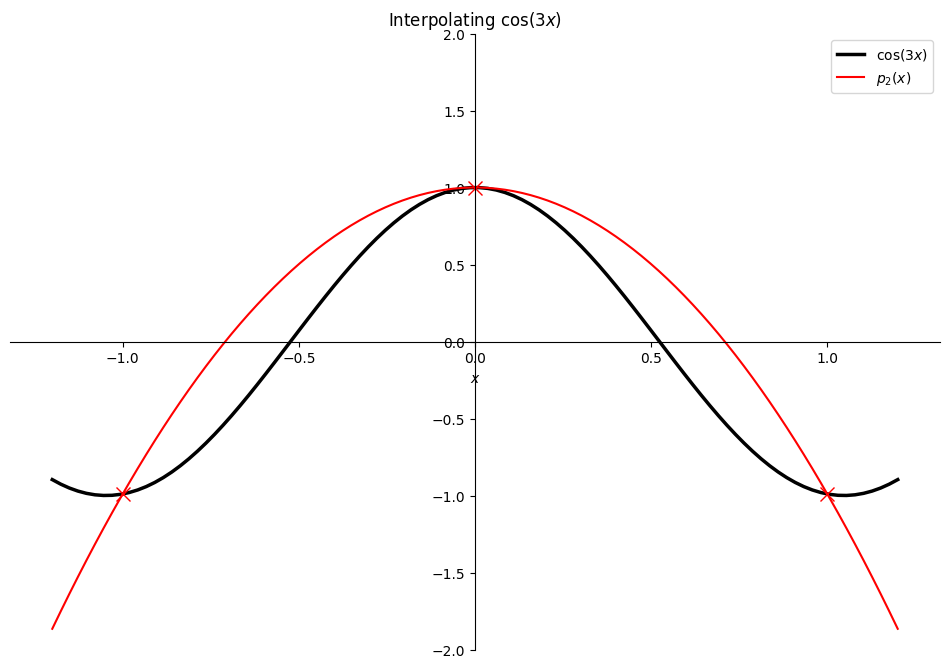

In [4]:
# Lines 38-43: Matplotlib examples gallery - Centred spines with arrows
# https://matplotlib.org/stable/gallery/spines/centered_spines_with_arrows.html
# Accessed 15/01/2023

import matplotlib.pyplot as plt

# Evaluate the original function
def f(x):
    return np.cos(3 * x)

x_plot = np.linspace(-1.2, 1.2, 100)    # create a dense enough x-axis to have a smooth plot
f_plot = f(x_plot)                      # evaluate the function at all these 100 points

# Plot the function
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_plot, f_plot, 'k-', linewidth=2.5, label=r'$\cos(3x)$')

# Find interpolating polynomial for 3 points
N = 3

# Create N nodes, equally spaced in [-1, 1]
xk = np.linspace(-1, 1, N)

# Find the interpolating polynomial coefficients (degree N-1)
p_coeffs = np.polyfit(xk, f(xk), N-1)

# Evaluate the polynomial using these coefficients, to plot it smoothly
p_plot = np.polyval(p_coeffs, x_plot)

# Plot the points and the polynomial
ax.plot(xk, f(xk), 'rx', markersize=10)
ax.plot(x_plot, p_plot, 'r-', linewidth=1.5, label=fr'$p_{{{N-1}}}(x)$')

# Label the plot
ax.set(title=r'Interpolating $\cos(3x)$', xlabel=r'$x$')
ax.set_ylim([-2, 2])

# Move the left and bottom spines to x = 0 and y = 0, respectively.
ax.spines["left"].set_position(("data", 0))
ax.spines["bottom"].set_position(("data", 0))
# Hide the top and right spines.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend()
plt.show()

Now that we have the coefficients of the interpolating polynomial, we can integrate that polynomial directly to give us an approximation of the integral of $\cos(3x)$ over $[-1, 1]$:

In [5]:
# Calculate the indefinite integral of the polynomial
# (returns coefficients, like np.polyfit earlier)
p_int = np.polyint(p_coeffs)

# Evaluate the definite integral over [-1, 1]
# We can use np.polyval() to evaluate the polynomial at x=1 and x=-1
I_approx = np.polyval(p_int, 1) - np.polyval(p_int, -1)

# Compare with the exact integral
def F(x):
    return np.sin(3*x) / 3

I_exact = F(1) - F(-1)

print(f'Exact value: I = {I_exact:.6f}\nApproximation: I_approx = {I_approx:.6f}')

Exact value: I = 0.094080
Approximation: I_approx = 0.673338


As expected when looking at the plot, the approximation is quite far off!

---
**📚 Learn more:**

- [`np.polyfit()`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) - Numpy documentation
- **ASC** sections 6.1, 6.2
- [Centred spines with arrows](https://matplotlib.org/stable/gallery/spines/centered_spines_with_arrows.html) - Matplotlib examples

---
🚩 **Exercise 2**

Repeat the calculations above to approximate $I$ by finding and integrating the interpolating polynomial passing through $N$ equally spaced points in $[-1, 1]$, with $N=6$ and $N=12$. Plot all 3 interpolating polynomials on the same graph, as above (include the one we just found for $N=3$ on your plot).

/var/folders/lt/1rnk3rn54ds_kmkv_yqmxsz40000gn/T/ipykernel_45564/220914011.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(xk, f(xk), 'rx', markersize=10, color = colors[N])
/var/folders/lt/1rnk3rn54ds_kmkv_yqmxsz40000gn/T/ipykernel_45564/220914011.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_plot, p_plot, 'r-', linewidth=1.5, label=fr'$p_{{{N-1}}}(x)$', color = colors[N])


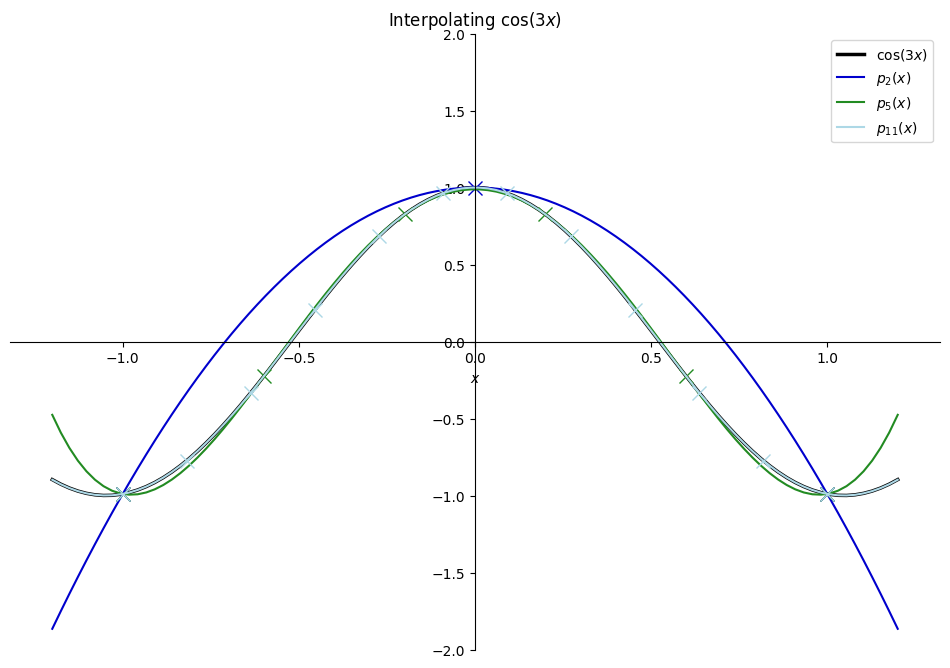

In [6]:
# Lines 38-43: Matplotlib examples gallery - Centred spines with arrows
# https://matplotlib.org/stable/gallery/spines/centered_spines_with_arrows.html
# Accessed 15/01/2023

import matplotlib.pyplot as plt

# Evaluate the original function
def f(x):
    return np.cos(3 * x)

x_plot = np.linspace(-1.2, 1.2, 100)    # create a dense enough x-axis to have a smooth plot
f_plot = f(x_plot)                      # evaluate the function at all these 100 points

# Plot the function
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_plot, f_plot, 'k-', linewidth=2.5, label=r'$\cos(3x)$')

# Color list
colors: dict[int: str] = {3: 'mediumblue', 6: 'forestgreen', 12: 'lightblue'}

# Repeat for N = 3, 6, 12
for N in [3, 6, 12]:
    # Find interpolating polynomial for 3 points
    # Create N nodes, equally spaced in [-1, 1]
    xk = np.linspace(-1, 1, N)

    # Find the interpolating polynomial coefficients (degree N-1)
    p_coeffs = np.polyfit(xk, f(xk), N-1)

    # Evaluate the polynomial using these coefficients, to plot it smoothly
    p_plot = np.polyval(p_coeffs, x_plot)

    # Plot the points and the polynomial
    ax.plot(xk, f(xk), 'rx', markersize=10, color = colors[N])
    ax.plot(x_plot, p_plot, 'r-', linewidth=1.5, label=fr'$p_{{{N-1}}}(x)$', color = colors[N])

    # Label the plot
    ax.set(title=r'Interpolating $\cos(3x)$', xlabel=r'$x$')
    ax.set_ylim([-2, 2])

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_position(("data", 0))
    # Hide the top and right spines.
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

ax.legend()
plt.show()

In [7]:
show('Exercise 2')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
### 1.3. Deriving quadrature rules

Note that if the function $f(x)$ we want to integrate is *itself* a polynomial of degree $N-1$ or below, then the method outlined above in section 1.2 gives the **exact** result:

$$
    I = \int_{-1}^1 f(x) \ dx = \int_{-1}^1 p_{N-1}(x) \ dx \qquad \text{if } f \text{ is a polynomial of degree at most } N-1.
$$

This is because in that case, the interpolating polynomial $p_{N-1}(x)$ passing through any $N$ points $(x_k, f(x_k))$ is exactly equal to $f(x)$. (For instance, if $f(x)$ is a line (a degree 1 polynomial), then the interpolating polynomial passing through 2 or more points $(x_k, f(x_k))$ will also be that same line.)

This leads us to an important definition:

---
### 🚩 Definition: Degree of precision of a quadrature rule

A quadrature rule has **degree of precision** $m$ if it integrates polynomials of degree up to $m$ **exactly**, but not polynomials of degree $m+1$.

---

Computing and integrating interpolating polynomials every time we want to approximate an integral can become computationally expensive. Recall that we defined a quadrature rule earlier (over $[-1, 1]$) as a set of nodes and weights we can use to approximate an integral as a weighted sum:

$$
I = \int_{-1}^1 f(x) \ dx \approx \sum_{k=0}^{N-1} w_k f(x_k).
$$

The idea here (in the first instance), is to find, given a set of $N$ nodes $x_k$, the corresponding weights $w_k$ such that our quadrature rule has degree of precision at least $N-1$. In other words, for **all** polynomials $p(x)$ of degree up to $N-1$, we want

$$
\int_{-1}^1 p(x) \ dx = \sum_{k=0}^{N-1} w_k p(x_k).
$$

Note that if we find weights $w_k$ such that the above is true for all polynomials of the form $p_j(x) = x^j$, with $j = 0, \dots, N-1$, then it will also be true for all linear combinations of the $p_j(x)$, i.e. for any arbitrary polynomial of degree up to $N-1$.

Finally, if we choose $p(x)$ to be $p_{N-1}(x)$, the interpolating polynomial of $f(x)$ passing through the $N$ points $(x_k, f(x_k))$, then by definition we have $p_{N-1}(x_k) = f(x_k)$. We therefore have

$$
\int_{-1}^1 p_{N-1}(x) \ dx = \sum_{k=0}^{N-1} w_k f(x_k) \approx  \int_{-1}^1 f(x) \ dx.
$$

This is our interpolatory quadrature rule. Note, in particular, that calculating the weights does not involve $f$ in any way. The nodes and weights characterising a particular quadrature rule (in the reference interval $[-1, 1]$ will always be the same; this allows us to approximate the integral of $f(x)$ by computing the integral of $p_{N-1}(x)$, without actually having to ever compute $p_{N-1}(x)$ itself.

---
**📚 Learn more:**

- **ASC** section 3.3
- **PCP** section 6.1
---

### 1.4. Newton-Cotes quadrature rules

When a quadrature rule uses $N$ equally spaced nodes within the interval $[-1, 1]$, it is referred to as a *Newton-Cotes* quadrature rule -- "closed" when the nodes include both boundary points, "open" when they don't.

We will use the process outlined above to derive some of the most commonly used quadrature rules.

*The figures below were generated using the code in `plots.py`. Feel free to have a go yourself!*

#### $N = 2$:  the trapezoid rule

Consider the "closed" Newton-Cotes rule for $N=2$. The two nodes are $x_0 = -1$ and $x_1 = 1$. We are approximating our function $f(x)$ over $[-1, 1]$ with the interpolating polynomial of degree 1 (a straight line), passing through the points $(-1, f(-1))$ and $(1, f(1))$. You might recognise this as the trapezoid rule from Week 5 (but just considering one trapezoid).

![Trapezoid rule.](graphics/trapz.png)

To derive the weights $w_0$ and $w_1$, we use the process described in section 1.3. We want the weights to satisfy

$$
\int_{-1}^1 p(x) \ dx = \sum_{k=0}^1 w_k p(x_k) = w_0 p(-1) + w_1 p(1),
$$

for $p(x) = 1$ and $p(x) = x$, so that the quadrature rule integrates all polynomials of degree up to 1 exactly. We have

\begin{align}
\int_{-1}^1 1 \ dx &= 1 - (-1) = 2 = w_0 + w_1 \\
\int_{-1}^1 x \ dx &= \frac{1}{2} (1^2 - (-1)^2) = 0 = -w_0 + w_1
\end{align}

The second equation gives $w_0 = w_1$. Substituting into the first equation, we get $w_0 = w_1 = 1$. The trapezoid rule over $[-1, 1]$ is therefore defined by the nodes $x_0 = -1, \ x_1 = 1$ and weights $w_0 = w_1 = 1$.

---
🚩 **Exercise 3**

Use the trapezoid rule to approximate the integral of the function shown in the figure above, $f(x) = e^{x-1} \sin(2x - 1.2) + 1.5$, over the interval $[-0.7, 0.9]$.

*Hint: use your function `quadrature()` from Exercise 1.*

In [8]:
# Define the interval, nodes, and weights
a, b = -0.7, 0.9
xk = np.array([-1.0, 1.0])
wk = np.array([1.0, 1.0])

# Define algebraic function to integrate
def f(x):
    return (np.exp(x - 1) * np.sin((2 * x) - 1.2)) + 1.5

# Use quadrature() to compute the approximation of the integral
I_approx = quadrature(f, xk, wk, a, b)

# Display the result with 6 decimal digits
print(f'The integral of f(x) over [{a}, {b}] is approximately {I_approx:.6f}.')

The integral of f(x) over [-0.7, 0.9] is approximately 2.733389.


In [9]:
show('Exercise 3')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
🚩 **Exercise 4**

In section 1.3, we saw that interpolatory quadrature rules with $N$ nodes have degree of precision **at least** $N-1$; sometimes, the degree of precision can be greater than $N-1$. What is the degree of precision of the trapezoid rule?

I think one because it could only do a one dimensional line perfectly.

In [23]:
show('Exercise 4')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
#### $N = 1$: the midpoint rule

The only Newton-Cotes quadrature rule for $N=1$ is "open", since we would have at least 2 nodes for any "closed" rule (the 2 boundary points). The only node is therefore taken in the middle of the interval $[-1, 1]$, that is $x_0 = 0$. The interpolation polynomial of degree 0 passing through the point $(0, f(0))$ is a constant, so this approximates the integral as the area of a rectangle. You may also recognise this from Week 5 -- this is the midpoint rule.

![Midpoint rule.](graphics/mid.png)

---
🚩 **Exercise 5**

Using the same process as above, derive the weight $w_0$ for the midpoint rule. What is the degree of precision of the midpoint rule?

Weight0 should be 2 since it only goes up to degree 0 of polynomial integrations. Keep in mind these are specific for the interval. The degree of precision of the midpoint rule is zero because it can only accurately integrate a flat line of dimension 0.

In [11]:
show('Exercise 5')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

#### $N = 3$: Simpson's rule

The "closed" quadrature with $N=3$ nodes is known as Simpson's rule. The three nodes are

$$
x_0 = -1, \quad x_1 = 0, \quad x_2 = 1.
$$

The interpolating polynomial passing through the points $(-1, f(-1))$, $(0, f(0))$, $(1, f(1))$ is a parabola (degree 2), so Simpson's rule approximates the integral by computing the blue surface below.

![Simpson's rule.](graphics/simpson.png)

---
🚩 **Exercise 6**

Show that the weights for Simpson's rule are given by

$$
w_0 = w_2 = \frac{1}{3}, \quad w_1 = \frac{4}{3}.
$$

Then, use Simpson's rule to approximate the integral of the function shown in the figure above, $f(x) = e^{x-1} \sin(2x - 1.2) + 1.5$, over the interval $[-0.7, 0.9]$. How does the result compare to Exercise 3?

*The exact integral is approximately 2.15968.*

Definite integrals from [-1, 1]:

1: w0 * p(-1) + w1 * p(0) + w2 * p(1) = 2
   w0 + w1 + w2 = 2

x: w0 * p(-1) + w1 * p(0) + w2 * p(1) = 0
   -0.5 * w0 + 0.5 * w2 = 0

x^2: w0 * p(-1) + w1 * p(0) + w2 * p(1) = 2/3
     w0 + w2 = 2/3

This sets up a system of linear equations in which we can use a program to solve or go by hand.

In [12]:
A: np.ndarray = np.array([[1, 1, 1], [-0.5, 0, 0.5], [1, 0, 1]])
b: np.ndarray = np.array([[2], [0], [2/3]])
wk: np.ndarray = (np.linalg.solve(A, b)).flatten()

# Define fn
def f(x: int|float|np.ndarray) -> int|float|np.ndarray:
    return (np.exp(x - 1) * np.sin((2 * x) - 1.2)) + 1.5

# Define inputs
a: float = -0.7
b: float = 0.9
xk: np.ndarray = np.array([-1, 0, 1])

quadrature(f, xk, wk, a, b)

2.1462052646885614

In [13]:
show('Exercise 6')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
🚩 **Exercise 7**

Show that the degree of precision of Simpson's rule is 3, and later confirm this with numerical evidence.

The degree of precision of Simpson's rule is 3 because of specific weights and similarities between two and three. This is stupid.

In [14]:
show('Exercise 7')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
### 1.5. Composite quadrature rules

Consider splitting the interval $[a, b]$ into $M$ sub-partitions of equal width $h = \frac{b - a}{M}$. We can compute the integral of $f$ over $[a, b]$ in multiple pieces:

$$
I = \int_a^b f(x) \ dx = \int_{c_0}^{c_1} f(x) \ dx
+ \int_{c_1}^{c_2} f(x) \ dx
+ \dots
+ \int_{c_{M-1}}^{c_M} f(x) \ dx,
\quad \text{with } c_0 = a \text{ and } c_M = b.
$$

The approximation of $I$ is then obtained using the quadrature rule over each of the $M$ sub-intervals. Choosing smaller intervals means that a low-degree interpolating polynomial is more likely to fit better to the function on these sub-intervals, which improves the accuracy of the estimate.

This is the generalisation of what we saw in Week 5 with Riemann sums, the midpoint rule, and the trapezoid rule -- these were all *composite* methods.

---
**📚 Learn more:**

- **ASC** section 3.4
- **PCP** sections 6.2, 6.3
---

🚩 **Exercise 8**

Write a function `composite_trapz()` which returns the approximate value of the integral of a function $f$ over the interval $[a, b]$, using the **composite** trapezoid rule, where the interval $[a, b]$ is split into $M$ partitions of equal width.

You can call your `quadrature()` function inside `composite_trapz()` to compute the approximation over each sub-interval.

You can test your function using the same example as in Week 5.

In [15]:
def composite_trapz(f, a: float, b: float, M: int) -> float:
    """Returns the approx value of the integral of f(x) over [a,b] using composite trapezoid rule,
    where interval is split into M partitions of = worth."""
    
    # Create a list of M points in range a, b
    spaced_points: np.ndarray = np.linspace(a, b, M + 1)

    #Define nodes and weights based off of trap rule
    xk = np.array([-1.0, 1.0])
    wk = np.array([1.0, 1.0])

    return sum([quadrature(f, xk, wk, spaced_points[idx], spaced_points[idx + 1]) for idx in range(M)])

# Define general inputs and fn
a, b = -0.7, 0.9
M = 50

def f(x: int|float|np.ndarray) -> int|float|np.ndarray:
    return (np.exp(x - 1) * np.sin((2 * x) - 1.2)) + 1.5

I_approx_2 = composite_trapz(f, a, b, M)

# Display the result with 6 decimal digits
print(f'The integral of f(x) over [{a}, {b}] with {M} pieces is approximately {I_approx_2:.6f}.')

The integral of f(x) over [-0.7, 0.9] with 50 pieces is approximately 2.159889.


In [16]:
show('Exercise 8')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
### 1.6. Rate of convergence for composite methods

When $M \to \infty$, the approximation $I_{\text{approx}}$ computed with a composite quadrature rule *converges* to $I$ -- the error $E = |I - I_{\text{approx}}| \to 0$. In fact, it can be shown that:

---
### 🚩 Definition: Rate of convergence of composite rules

Using a composite quadrature rule with sub-intervals with sufficiently small width $h$, we have

$$
E = \alpha h^r,
$$

where $\alpha$ is some constant, and $r$ is the **rate of convergence** of the composite method. We say that the method is of *order* $r$.

---

Note that $r$ is not the same as the degree of precision! It is a property of composite rules specifically. You have, in fact, already estimated $r$ for a few composite rules in the last few exercises of the Week 5 notebook.

---
**📚 Learn more:**

- **PCP** section 6.5
- **ASC** section 3.4
---

🚩 **Exercise 9**

Consider the integral

$$
I = \int_{-1}^1 x e^x \ dx = \frac{2}{e},
$$

where $e = e^1$. Use your function `composite_trapz()` to approximate $I$ using $M = 2, 4, 8, 16, 32, 64$ intervals. Compute the absolute error between the exact value of the integral and your approximation for each value of $M$, and plot your results on a log-log scale, with the size $h$ of the intervals on the x-axis and the absolute error on the y-axis.

Based on this numerical evidence, what seems to be the convergence rate $r$ of the composite trapezoid rule?

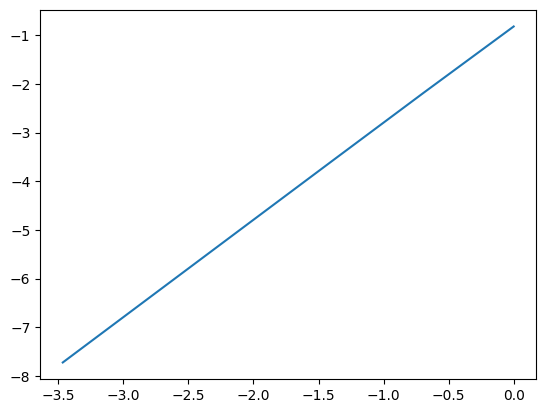

In [17]:
M_list: list[int] = [2 ** x for x in range(1, 7)]
a, b = -1.0, 1.0

def f(x):
    return x * np.exp(x)

h_vals: list[float] = []
approx: list[float] = []
error: list[float] = []

for M in M_list:
    h_vals.append((b - a) / M)
    approx.append(composite_trapz(f, a, b, M))
    error.append(np.abs(composite_trapz(f, a, b, M) - 0.735758882342885))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(np.log(h_vals), np.log(error))


In [18]:
show('Exercise 9')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
## 2. Introduction to numerical differentiation

We can also use numerical methods to compute approximations to derivatives. Numerical differentiation is typically performed by replacing a **derivative** with a **difference** of finite size.

Consider the derivative of a function $F \left( x \right)$. One definition for the derivative is

$$
  F' \left( x \right) = \lim_{\Delta x \rightarrow 0} \frac{F \left( x + \Delta x \right) - F \left( x \right)}{\Delta x}.
$$

Note that here $\Delta x$ is notation for a single parameter, and should not be considered to be a product. A numerical approximation for the derivative can be reached by removing the limit, and considering a non-zero step size $\Delta x > 0$. Here this leads to the **forward difference** approximation

$$
  F' \left( x \right) \approx D_1 \left( x \right) = \frac{F \left( x + \Delta x \right) - F \left( x \right)}{\Delta x}.
$$

Alternatively the derivative can be obtained via

$$
  F' \left( x \right) = \lim_{\Delta x \rightarrow 0} \frac{F \left( x + \Delta x \right) - F \left( x - \Delta x \right)}{2 \Delta x}.
$$

Removing the limit now leads to the **centred difference** approximation

$$
  F' \left( x \right) \approx D_C \left( x \right) = \frac{F \left( x + \Delta x \right) - F \left( x - \Delta x \right)}{2 \Delta x}.
$$

There are (many!) different ways to formulate approximations for numerical derivatives, and these will typically have different properties.

---
**📚 Learn more:**

- **ASC** section 3.2

---
🚩 **Exercise 10**

Consider the function

$$
  F \left( x \right) = \left[ 1 + \cos \left( \tan \left( x \right) \right) \right]^2.
$$

- Plot this function in the interval $x \in \left[ 0, 0.45 \pi \right]$.

- Use the forward difference approximation to compute a numerical approximation for the derivative at $2,000$ equally spaced points in the interval $x \in \left[ 0, 0.45 \pi \right]$, with $\Delta x = 0.01$.  Store the approximation in a vector variable `F_derivative_approx`.

- The derivative of the function $F \left( x \right)$, at the $2,000$ points specified earlier, is given in the data file `F_derivative.txt`.  The derivative values can be loaded into a Numpy array `F_derivative` using the function `np.loadtxt()`:
```python
F_derivative = np.loadtxt("F_derivative.txt")
```
Compute the error `F_derivative_approx - F_derivative` over the interval. Then, create a figure with 2 subplots.
    - On the top axes, plot both `F_derivative` and `F_derivative_approx`.
    - On the bottom axes, plot the error.
    
What do you observe? Where does the error seem to be the largest?

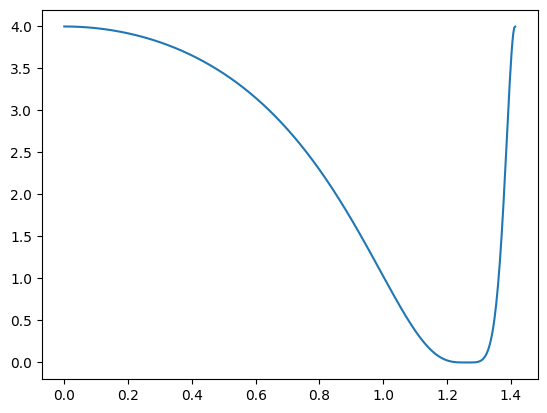

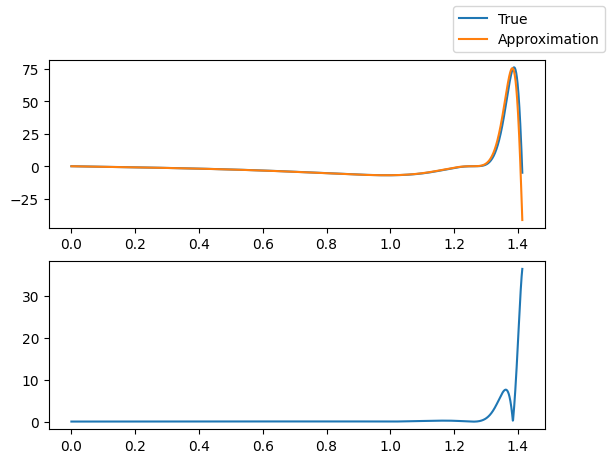

In [19]:
def F(x):
    return (1 + np.cos(np.tan(x))) ** 2
x_values = np.linspace(0, 0.45 * np.pi, 500)
y_values = F(x_values)

figure, ax = plt.subplots(1, 1)
ax.plot(x_values, y_values)

x = np.linspace(0, np.pi * 0.45, 2000)
change_x: float = 0.01
F_derivative_approx = (F(x + change_x) - F(x)) / change_x
F_derivative = np.loadtxt("F_derivative.txt")

error = np.abs(F_derivative_approx - F_derivative)

figure, ax = plt.subplots(2, 1)
ax[0].plot(x, F_derivative, label = "True")
ax[0].plot(x, F_derivative_approx, label = "Approximation")
ax[1].plot(x, error)
figure.legend()

# Error is largest at the nonlinear/u-shaped part. Otherwise, this is realitively correct.
# I think this is because as x changes a little, it changes a lot during those intervals,
# so the approximation is less accurate.

In [20]:
show('Exercise 10')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…

---
🚩 **Exercise 11**

Repeat Exercise 10, this time using the centred difference approximation. How does the error compare to Exercise 10? Is this what you expected?

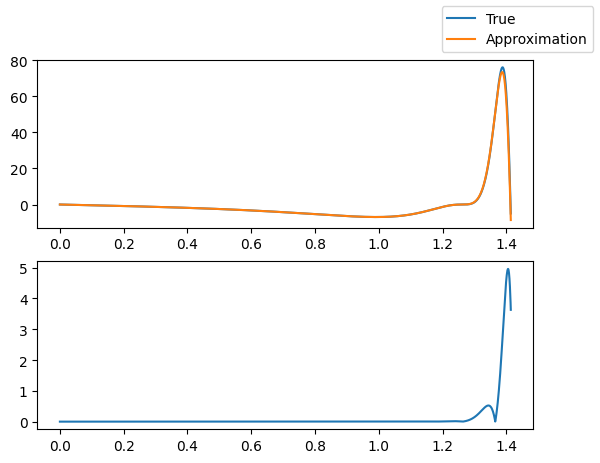

In [21]:
x = np.linspace(0, np.pi * 0.45, 2000)
change_x: float = 0.01
F_derivative_approx = (F(x + change_x) - F(x - change_x)) / (2 * change_x)
F_derivative = np.loadtxt("F_derivative.txt")

error = np.abs(F_derivative_approx - F_derivative)

figure, ax = plt.subplots(2, 1)
ax[0].plot(x, F_derivative, label = "True")
ax[0].plot(x, F_derivative_approx, label = "Approximation")
ax[1].plot(x, error)
figure.legend()

# Way lower error compared to front difference method. Not what I expected.

In [22]:
show('Exercise 11')

Accordion(children=(Output(layout=Layout(border_bottom='1px solid green', border_left='1px solid green', borde…